In [2]:
# imports
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import scipy.stats as sstats
from os.path import join, exists
from sklearn.metrics import matthews_corrcoef

In [3]:
PROJ_DIR = '/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/'
DATA_DIR = 'data/'
FIGS_DIR = 'figures/'
OUTP_DIR = 'output/'

In [17]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, 'data.csv'), index_col=0, header=0)

In [21]:
imaging_qc = ['imgincl_dmri_include.baseline_year_1_arm_1', 'imgincl_dmri_include.2_year_follow_up_y_arm_1',
              'imgincl_rsfmri_include.baseline_year_1_arm_1', 'imgincl_rsfmri_include.2_year_follow_up_y_arm_1',
              'rsfmri_c_ngd_meanmotion.baseline_year_1_arm_1', 'rsfmri_c_ngd_meanmotion.2_year_follow_up_y_arm_1',
              'rsfmri_c_ngd_ntpoints.baseline_year_1_arm_1', 'rsfmri_c_ngd_ntpoints.2_year_follow_up_y_arm_1',
              'imgincl_t1w_include.baseline_year_1_arm_1', 'imgincl_t1w_include.2_year_follow_up_y_arm_1',
              'imgincl_t2w_include.baseline_year_1_arm_1', 'imgincl_t2w_include.2_year_follow_up_y_arm_1']
nihtb = ['nihtbx_picvocab_uncorrected.change_score',
         'nihtbx_flanker_uncorrected.change_score',
         #'nihtbx_list_uncorrected.change_score',
         #'nihtbx_cardsort_uncorrected.change_score',
         'nihtbx_pattern_uncorrected.change_score',
         'nihtbx_picture_uncorrected.change_score',
         'nihtbx_reading_uncorrected.change_score']
puberty = [#'sex.baseline_year_1_arm_1', 'sex.2_year_follow_up_y_arm_1', 
           'pds_p_ss_male_category.baseline_year_1_arm_1', 'pds_p_ss_male_category.2_year_follow_up_y_arm_1', 
           'pds_p_ss_female_category.baseline_year_1_arm_1', 'pds_p_ss_female_category.2_year_follow_up_y_arm_1', 
           'pds_p_ss_male_category_2.baseline_year_1_arm_1', 'pds_p_ss_male_category_2.2_year_follow_up_y_arm_1', 
           'pds_p_ss_female_category_2.baseline_year_1_arm_1', 'pds_p_ss_female_category_2.2_year_follow_up_y_arm_1']
demographics = ['demo_prnt_ethn_v2', 'demo_prnt_marital_v2', 'demo_prnt_ed_v2', 'demo_comb_income_v2', 
                'demo_race_a_p___10', 'demo_race_a_p___11', 'demo_race_a_p___12', 'demo_race_a_p___13',
                'demo_race_a_p___14', 'demo_race_a_p___15', 'demo_race_a_p___16', 'demo_race_a_p___17',
                'demo_race_a_p___18', 'demo_race_a_p___19', 'demo_race_a_p___20', 'demo_race_a_p___21',
                'demo_race_a_p___22', 'demo_race_a_p___23', 'demo_race_a_p___24', 'demo_race_a_p___25']
age = [#'mri_info_manufacturer.baseline_year_1_arm_1', 
       #'mri_info_manufacturer.2_year_follow_up_y_arm_1', 
       'interview_age.baseline_year_1_arm_1',
       'interview_age.2_year_follow_up_y_arm_1']
family = ['rel_family_id',
          'rel_group_id',
          'rel_ingroup_order',
          'rel_relationship']
site = ['site_id_l.baseline_year_1_arm_1', 'site_id_l.2_year_follow_up_y_arm_1']
sex = ['sex.baseline_year_1_arm_1', 'sex.2_year_follow_up_y_arm_1']

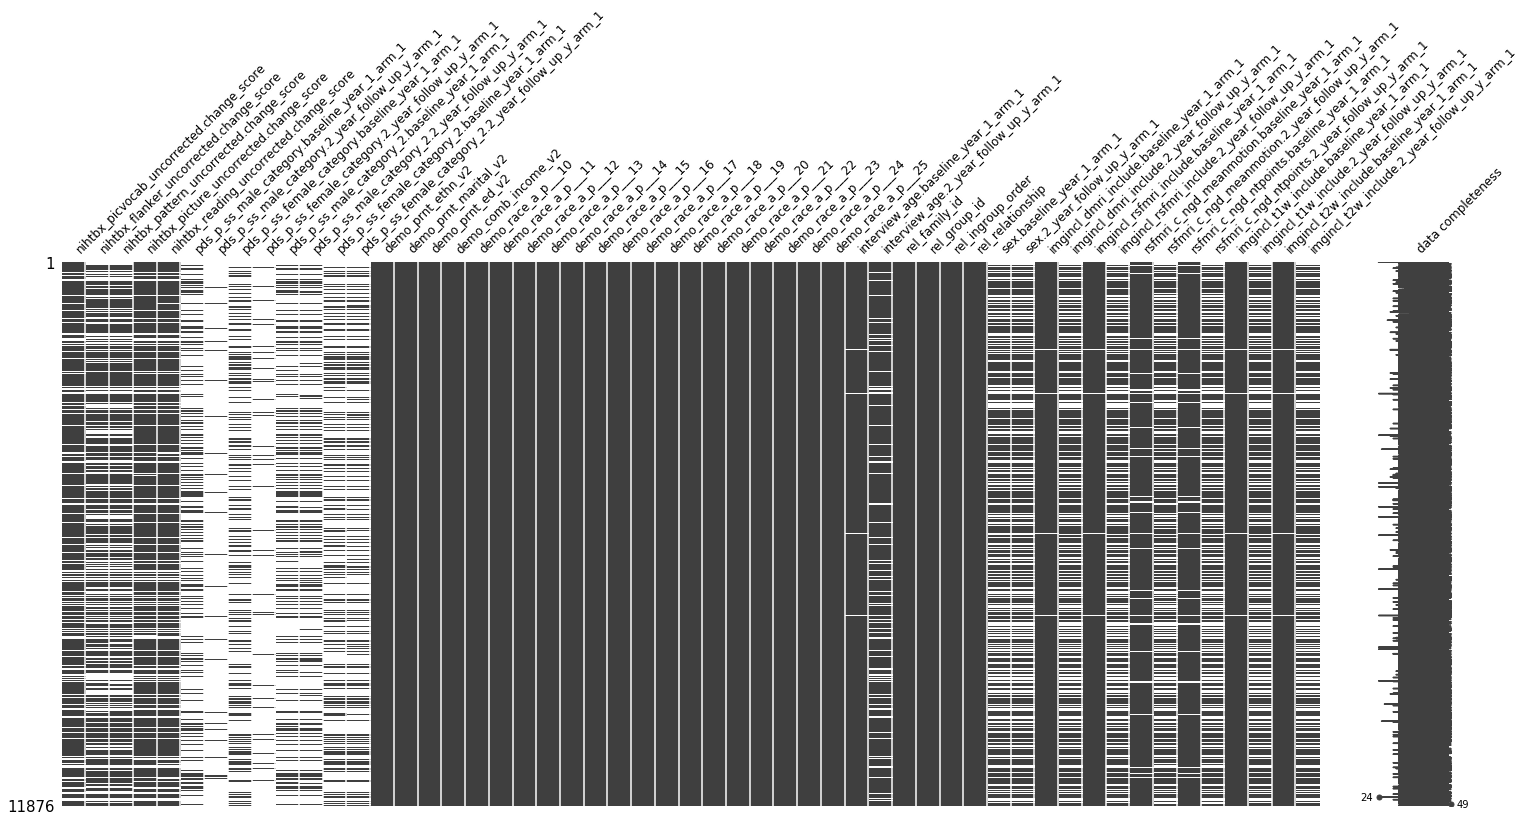

In [23]:
matrix_df = df[nihtb + puberty + demographics + age + family + sex + imaging_qc]
msno.matrix(matrix_df, labels=True, fontsize=12)

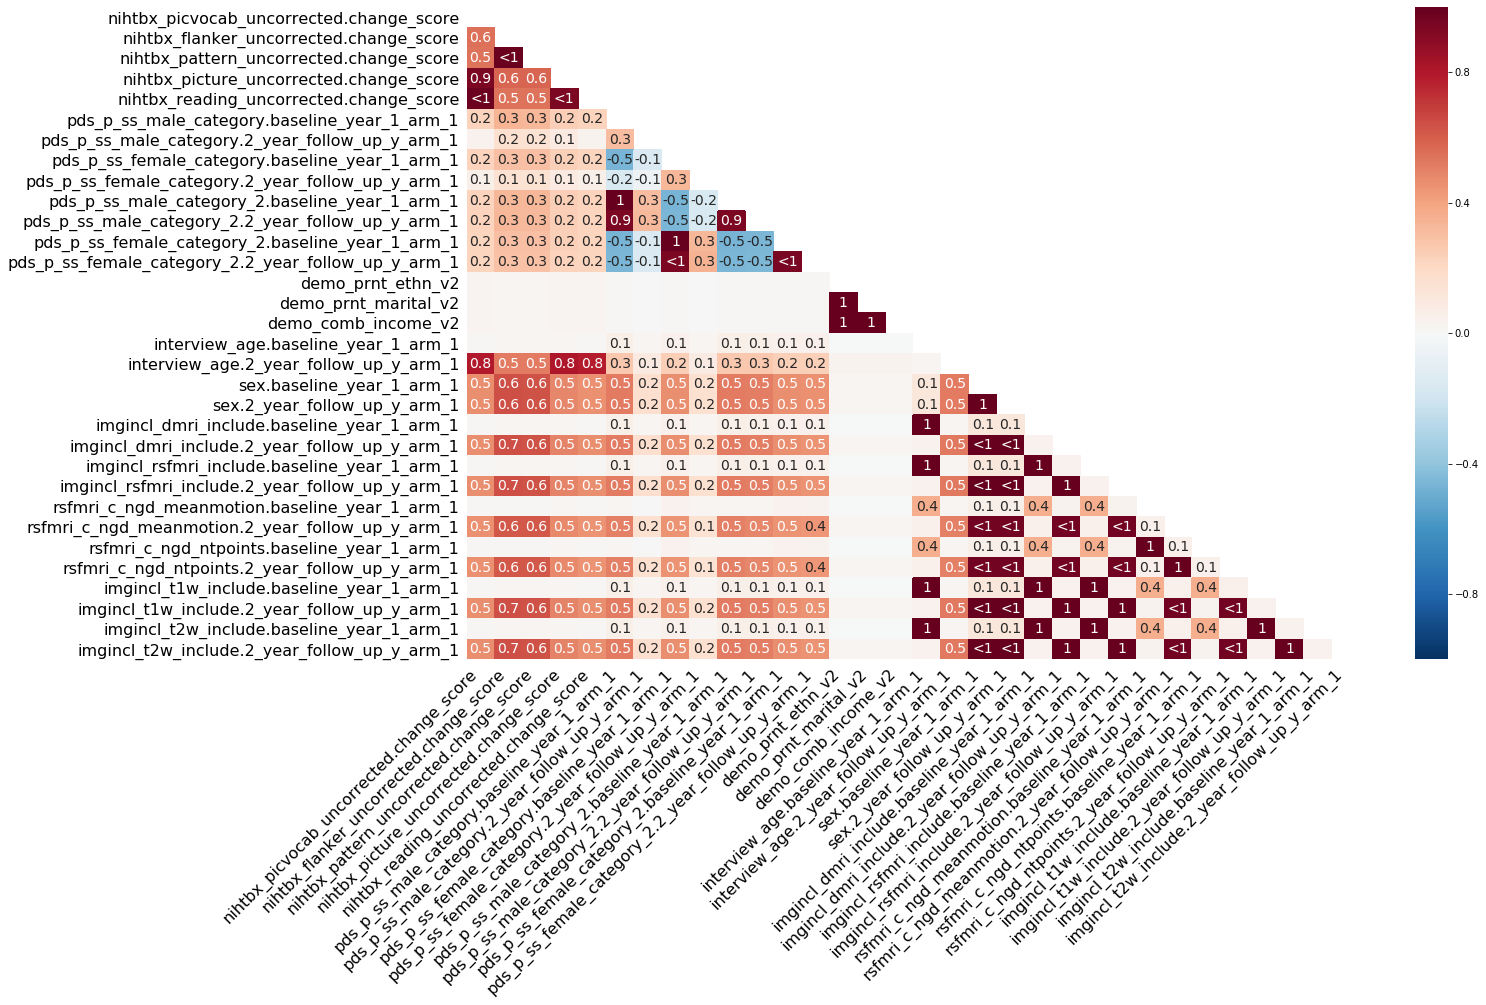

In [25]:
msno.heatmap(matrix_df, cmap='RdBu_r')

In [6]:
sex = pd.get_dummies(df[['sex.baseline_year_1_arm_1', 
                         'sex.2_year_follow_up_y_arm_1']])
sex_cols = list(sex.columns)
df = pd.concat([df, sex], axis=1)
df.drop(['sex.baseline_year_1_arm_1', 
         'sex.2_year_follow_up_y_arm_1'], 
        axis=1, inplace=True)
mri = pd.get_dummies(df[['mri_info_manufacturer.baseline_year_1_arm_1',
                         'mri_info_manufacturer.2_year_follow_up_y_arm_1']])
mri_cols = list(mri.columns)
df = pd.concat([df, mri], axis=1)
df.drop(['mri_info_manufacturer.baseline_year_1_arm_1',
         'mri_info_manufacturer.2_year_follow_up_y_arm_1'], 
        axis=1, inplace=True)
site = pd.get_dummies(df[['site_id_l.baseline_year_1_arm_1', 
                          'site_id_l.2_year_follow_up_y_arm_1']])
site_cols = list(site.columns)
df = df = pd.concat([df, site], axis=1)
df.drop(['site_id_l.baseline_year_1_arm_1',
         'site_id_l.2_year_follow_up_y_arm_1'], 
        axis=1, inplace=True)

What am I going to do?
If I add baseline and 2yfu imaging QC variables then any value less than 2 is an exclude.
and I can convert everything less than 2 to np.nan to use for missingness assessments. 
Need to find out what the "mean motion" value is. FD? yes, in mm.

In [8]:
# build a mini dataset that represents missingness on each variable
keep = nihtb + puberty + demographics + age + family + sex_cols + mri_cols + site_cols
miss_df = df[keep]

In [9]:
miss_df.head()

,nihtbx_picvocab_uncorrected.change_score,nihtbx_flanker_uncorrected.change_score,nihtbx_pattern_uncorrected.change_score,nihtbx_picture_uncorrected.change_score,nihtbx_reading_uncorrected.change_score,pds_p_ss_male_category.baseline_year_1_arm_1,pds_p_ss_male_category.2_year_follow_up_y_arm_1,pds_p_ss_female_category.baseline_year_1_arm_1,pds_p_ss_female_category.2_year_follow_up_y_arm_1,pds_p_ss_male_category_2.baseline_year_1_arm_1,...,site_id_l.2_year_follow_up_y_arm_1_site12,site_id_l.2_year_follow_up_y_arm_1_site13,site_id_l.2_year_follow_up_y_arm_1_site14,site_id_l.2_year_follow_up_y_arm_1_site15,site_id_l.2_year_follow_up_y_arm_1_site16,site_id_l.2_year_follow_up_y_arm_1_site17,site_id_l.2_year_follow_up_y_arm_1_site18,site_id_l.2_year_follow_up_y_arm_1_site19,site_id_l.2_year_follow_up_y_arm_1_site20,site_id_l.2_year_follow_up_y_arm_1_site21
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV003RTV85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
NDAR_INV005V6D2C,-7.320261,NaN,NaN,-1.426025,4.740741,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
NDAR_INV007W6H7B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
NDAR_INV00BD7VDC,4.037006,NaN,NaN,-9.013315,1.435121,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
NDAR_INV00CY2MDM,2.084540,-3.272727,13.417598,3.956665,-4.083617,2.0,NaN,NaN,NaN,2.0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
missing = miss_df.isna().replace({True: 1, False: 0})

In [13]:
for col1 in missing:
    for col2 in miss_df:
        if col1 != col2:
            temp_df = pd.concat([missing[col1], miss_df[col2]], axis=1)
            temp_df.dropna(how='any', inplace=True)
            if len(miss_df[col2].dropna().unique()) == 2:
                mcc = matthews_corrcoef(temp_df[col1].values, temp_df[col2].values)
                print(f'{col1} missingness assoc with {col2} value\nmcc = {np.round(mcc, 4)}')
            else:
                pbr = sstats.pointbiserialr(temp_df[col1].values, temp_df[col2].values)
                if pbr[1] < 0.01:
                    print(f'{col1} missingness assoc with {col2} value\nr = {np.round(pbr[0], 4)}\t\tp = {np.round(pbr[1], 4)}')
                else:
                    pass
        else:
            pass

nihtbx_picvocab_uncorrected.change_score missingness assoc with pds_p_ss_female_category.2_year_follow_up_y_arm_1 value
r = -0.1108		p = 0.0094
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_prnt_ethn_v2 value
r = 0.0275		p = 0.0027
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_prnt_marital_v2 value
r = 0.0494		p = 0.0
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_comb_income_v2 value
r = 0.0487		p = 0.0
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_race_a_p___10 value
mcc = -0.0953
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_race_a_p___11 value
mcc = 0.0988
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_race_a_p___12 value
mcc = -0.0074
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_race_a_p___13 value
mcc = 0.0011
nihtbx_picvocab_uncorrected.change_score missingness assoc with demo_race_a_p___14 value
mcc = -0.0057
nihtbx_picv

nihtbx_picvocab_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = -0.0607
nihtbx_picvocab_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = -0.0595
nihtbx_picvocab_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = -0.0594
nihtbx_picvocab_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = -0.0556
nihtbx_picvocab_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = -0.092
nihtbx_picvocab_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = -0.0415
nihtbx_flanker_uncorrected.change_score missingness assoc with nihtbx_pattern_uncorrected.change_score value
r = -0.0378		p = 0.0008
nihtbx_flanker_uncorrected.change_score missingness assoc with nihtbx_picture_uncorrected.change_score value
r =

nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = -0.0475
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = -0.0327
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = -0.1062
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = -0.1235
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = -0.0732
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = -0.0952
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = -0.1016
nihtbx_flanker_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = -0.0609


nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = -0.0544
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = -0.0956
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = -0.0234
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = -0.0822
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = -0.0568
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = -0.089
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = -0.046
nihtbx_pattern_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = -0.0341
ni

nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = -0.0748
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = -0.0568
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = -0.092
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = -0.0243
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = -0.0693
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = -0.0334
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = -0.0476
nihtbx_picture_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = -0.0467
n

nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = -0.0905
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.baseline_year_1_arm_1_site21 value
mcc = -0.0366
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = -0.0151
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = -0.0418
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = -0.0756
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = -0.0485
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = -0.0772
nihtbx_reading_uncorrected.change_score missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = -0.0205
nihtbx_re

pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = -0.065
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = -0.0779
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = -0.0497
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = -0.1223
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = -0.079
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = -0.0682
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = -0.049
pds_p_ss_male_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
m

pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0232
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = -0.0387
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0319
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0428
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = -0.0674
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0012
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = -0.0189
pds_p_ss_male_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year

pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = -0.0485
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = -0.0444
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = -0.0783
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = -0.053
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = -0.0761
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = -0.0842
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = -0.0625
pds_p_ss_female_category.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_ar

pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = -0.0689
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0187
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = -0.0176
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0264
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = -0.0065
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.018
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = -0.0446
pds_p_ss_female_category.2_year_follow_up_y_arm_1 missingness assoc with site_id

pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = -0.1591
pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems value
mcc = -0.1076
pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = -0.3191
pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = -0.0556
pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = -0.087
pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = -0.0719
pds_p_ss_male_category_2.baseline_year_1_arm_1 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = -0.0735
pds_p_ss_male_category_

pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = -0.019
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0167
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = -0.0038
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = -0.1565
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems value
mcc = -0.1027
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = -0.317
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1 missingness assoc wi

pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with demo_race_a_p___24 value
mcc = 0.0053
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with demo_race_a_p___25 value
mcc = 0.0026
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with interview_age.baseline_year_1_arm_1 value
r = 0.0511		p = 0.0
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with interview_age.2_year_follow_up_y_arm_1 value
r = 0.1063		p = 0.0
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with rel_relationship value
r = -0.0342		p = 0.0002
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = -0.9781
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.4795
pds_p_ss_female_category_2.baseline_year_1_arm_1 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = -0.9781
pds_p_ss_female_category_2.b

pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with demo_race_a_p___20 value
mcc = -0.0098
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with demo_race_a_p___21 value
mcc = -0.011
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with demo_race_a_p___22 value
mcc = -0.0069
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with demo_race_a_p___23 value
mcc = -0.0025
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with demo_race_a_p___24 value
mcc = 0.0059
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with demo_race_a_p___25 value
mcc = 0.0036
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with interview_age.baseline_year_1_arm_1 value
r = 0.0493		p = 0.0
pds_p_ss_female_category_2.2_year_follow_up_y_arm_1 missingness assoc with interview_age.2_year_follow_up_y_arm_1 value
r = 0.106		p = 0.0
pds_p_ss_female_category_2.2_year_follow_up

demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___10 value
mcc = -0.022
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___11 value
mcc = 0.025
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___12 value
mcc = -0.0024
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___13 value
mcc = -0.0003
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___14 value
mcc = -0.0006
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___15 value
mcc = -0.0002
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___16 value
mcc = -0.0004
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___17 value
mcc = -0.0008
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___18 value
mcc = -0.0013
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___19 value
mcc = -0.0017
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___20 value
mcc = -0.0015
demo_prnt_ethn_v2 missingness assoc with demo_race_a_p___21 value
mcc = -0.0011
demo_prnt_ethn_v2 missingness assoc with de

demo_prnt_marital_v2 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = -0.0075
demo_prnt_marital_v2 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = -0.005
demo_prnt_marital_v2 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0103
demo_prnt_marital_v2 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = -0.006
demo_prnt_marital_v2 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems value
mcc = -0.0038
demo_prnt_marital_v2 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = -0.0106
demo_prnt_marital_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = -0.0018
demo_prnt_marital_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = -0.0024
demo_prnt_marital_v2 missingness assoc

demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
demo_prnt_ed_v2 missingness assoc with site_id_l.baseline_ye

demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = -0.0019
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = -0.0024
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = -0.0026
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = -0.0024
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = -0.0019
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = -0.0033
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = -0.0024
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = -0.0019
demo_comb_income_v2 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = -0.0023
demo_comb_income_v2 missingness assoc with site_id_l.2_

demo_race_a_p___11 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
demo_race_a_p___11 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
demo_race_a_p___11 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
demo_race_a_p___11 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
demo_race_a_p___11 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
demo_race_a_p___11 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
demo_race_a_p___11 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
demo_race_a_p___11 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
demo_race_a_p___11 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
demo_race_a_p___11 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
demo_race_a_p___11 missingness assoc with mri_info_manufacture

demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
demo_race_a_p___12 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
demo_race_a_p___12 missingness

demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = 0.0
demo_race_a_p___13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = 0.0


demo_race_a_p___15 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
demo_race_a_p___15 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
demo_race_a_p___15 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
demo_race_a_p___15 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
demo_race_a_p___15 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
demo_race_a_p___15 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value


demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
demo_race_a_p___16 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
demo_race_a_p___16 missingness

demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
demo_race_a_p___17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0


demo_race_a_p___18 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
demo_race_a_p___18 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
demo_race_a_p___18 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___12 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___13 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___14 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___15 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___16 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
demo_race_a_p___19 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
demo_ra

demo_race_a_p___20 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
demo_race_a_p___20 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
demo_race_a_p_

demo_race_a_p___21 missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
demo_race_a_p___21 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
dem

mcc = 0.0
demo_race_a_p___22 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___12 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___13 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___14 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___15 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___16 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
demo_race_a_p___23 missingness assoc with d

demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
demo_race_a_p___24 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
demo_race_a_p___24 missingness

demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
demo_race_a_p___25 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0


interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = -0.0149
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = -0.0117
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = -0.0205
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = -0.0147
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = -0.0115
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = -0.014
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = -0.0179
interview_age.baseline_year_1_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = -0.0151
interview_age.2_year_follow_up_y_

interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = -0.0761
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = -0.0698
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = -0.0546
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = -0.0959
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = -0.0684
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = -0.0537
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = -0.0652
interview_age.2_year_follow_up_y_arm_1 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = -0.0835
intervie

rel_group_id missingness assoc with demo_race_a_p___23 value
mcc = 0.0
rel_group_id missingness assoc with demo_race_a_p___24 value
mcc = 0.0
rel_group_id missingness assoc with demo_race_a_p___25 value
mcc = 0.0
rel_group_id missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
rel_group_id missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
rel_group_id missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
rel_group_id missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
rel_group_id missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
rel_group_id missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
rel_group_id missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
rel_group_id missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
rel_

rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
rel_ingroup_order missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
rel_ingroup_order missingness assoc with

rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
rel_relationship missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
sex.baseline_year_1_arm_1_F missingness assoc with demo_race_a_p___10 value
mcc = 0.0
sex.baseline_year_1_arm_1_F missingness assoc with demo_race_a_p___11 value
mcc = 0.0
sex.baseline_year_1_arm_1_F missingness asso

sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___19 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___20 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___21 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___22 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___23 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___24 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with demo_race_a_p___25 value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
sex.baseline_year_1_arm_1_M missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL S

sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_F missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
sex.2_year_follow_u

sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
sex.2_year_follow_up_y_arm_1_M missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
sex.2_year_follow_u

mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
mri_info_manu

mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems missingness assoc with site_id_l.baseline_year_1_arm_1_s

mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS missingness assoc with site_id_l.basel

mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mc

mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Syst

mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___19 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___20 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___21 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___22 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___23 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___24 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with demo_race_a_p___25 value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS missingness assoc with sex.basel

site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site01 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0


site_id_l.baseline_year_1_arm_1_site02 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site02 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_Philip

site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site03 missingness assoc with si

site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site04 missingness assoc with si

site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.baseline_year_1_arm_1_site21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site05 missingness a

site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site06 m

site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site07 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site08 m

site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___13 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___14 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___15 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___16 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site09 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_

site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site10 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0


site_id_l.baseline_year_1_arm_1_site11 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site11 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l

site_id_l.baseline_year_1_arm_1_site12 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site12 missingne

site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site13 missingness assoc with si

site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site14 missingness asso

site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site15 m

site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site17 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site17 missingness assoc with d

site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___13 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___14 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___15 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___16 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site18 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_

site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site19 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0


site_id_l.baseline_year_1_arm_1_site20 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site20 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_Philip

site_id_l.baseline_year_1_arm_1_site21 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_Philips Medical Systems value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site21 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
site_id_l.baseli

site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site08 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
site_id_l.baseline_year_1_arm_1_site22 missingness assoc with si

site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site01 missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site0

site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.baseline_year_1_arm_1_site21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site02 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1

site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site03 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
site_id_l.2_year

site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site04 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0
site_id_l.2_year

site_id_l.2_year_follow_up_y_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site05 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site06 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site06 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site06 missingness assoc wi

site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___12 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___13 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___14 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___16 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site07 missingness assoc with demo_race_a_p___19 value
mcc = 0.0


site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site08 missingness assoc with sex.baseline_year_1_arm_1_F value
m

site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site09 missingness assoc with sex.2_year_follow

site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site10 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS v

site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_SIEMENS value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site01 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site02 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site03 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site04 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site05 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site06 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site11 missingness assoc with site_id_l.baseline_year_1_arm_1_site07 value
mcc = 0.0
site_id_l.2_year_follow_

site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site09 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site12 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site13 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site14 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site12 missingness assoc with site_id_l.baseline_year_1_arm_1_site16 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site1

site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site13 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1

site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.baseline_year_1_arm_1_site22 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site01 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site02 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site03 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site14 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site04 value
mcc = 0.0
site_id_l.2_year_follow_up_y

site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site05 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site06 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site07 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site08 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site09 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site15 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
site_id_l.2_year

site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site12 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site13 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site14 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site16 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
site_id_l.2_year

site_id_l.2_year_follow_up_y_arm_1_site17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site16 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site19 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site17 missingness assoc with site_id_l.2_year_follow_up_y_arm_1_site21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site18 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site18 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site18 missingness assoc wi

site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___10 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___11 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___12 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___13 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___14 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___15 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___16 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___17 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___18 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site19 missingness assoc with demo_race_a_p___19 value
mcc = 0.0


site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with demo_race_a_p___20 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with demo_race_a_p___21 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with demo_race_a_p___22 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with demo_race_a_p___23 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with demo_race_a_p___24 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with demo_race_a_p___25 value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site20 missingness assoc with sex.2

site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with sex.baseline_year_1_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with sex.baseline_year_1_arm_1_M value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with sex.2_year_follow_up_y_arm_1_F value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with sex.2_year_follow_up_y_arm_1_M value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_GE MEDICAL SYSTEMS value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_Philips Medical Systems value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with mri_info_manufacturer.baseline_year_1_arm_1_SIEMENS value
mcc = 0.0
site_id_l.2_year_follow_up_y_arm_1_site21 missingness assoc with mri_info_manufacturer.2_year_follow_up_y_arm_1_GE MEDICAL SYSTEMS v

In [21]:
missing.corr(method='kendall')

,nihtbx_picvocab_uncorrected.change_score,nihtbx_flanker_uncorrected.change_score,nihtbx_pattern_uncorrected.change_score,nihtbx_picture_uncorrected.change_score,nihtbx_reading_uncorrected.change_score,pds_p_ss_male_category.baseline_year_1_arm_1,pds_p_ss_male_category.2_year_follow_up_y_arm_1,pds_p_ss_female_category.baseline_year_1_arm_1,pds_p_ss_female_category.2_year_follow_up_y_arm_1,pds_p_ss_male_category_2.baseline_year_1_arm_1,...,site_id_l.2_year_follow_up_y_arm_1_site12,site_id_l.2_year_follow_up_y_arm_1_site13,site_id_l.2_year_follow_up_y_arm_1_site14,site_id_l.2_year_follow_up_y_arm_1_site15,site_id_l.2_year_follow_up_y_arm_1_site16,site_id_l.2_year_follow_up_y_arm_1_site17,site_id_l.2_year_follow_up_y_arm_1_site18,site_id_l.2_year_follow_up_y_arm_1_site19,site_id_l.2_year_follow_up_y_arm_1_site20,site_id_l.2_year_follow_up_y_arm_1_site21
nihtbx_picvocab_uncorrected.change_score,1.000000,0.547170,0.544270,0.943917,0.982588,0.232251,0.040906,0.227336,0.056265,0.232112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nihtbx_flanker_uncorrected.change_score,0.547170,1.000000,0.988607,0.580795,0.544138,0.335985,0.156501,0.303353,0.149222,0.335770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nihtbx_pattern_uncorrected.change_score,0.544270,0.988607,1.000000,0.580622,0.543459,0.331887,0.155536,0.301103,0.147201,0.331669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nihtbx_picture_uncorrected.change_score,0.943917,0.580795,0.580622,1.000000,0.945182,0.249391,0.092608,0.235529,0.087838,0.249255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nihtbx_reading_uncorrected.change_score,0.982588,0.544138,0.543459,0.945182,1.000000,0.229333,0.038160,0.225199,0.056084,0.229191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site_id_l.2_year_follow_up_y_arm_1_site17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
site_id_l.2_year_follow_up_y_arm_1_site18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
site_id_l.2_year_follow_up_y_arm_1_site19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
site_id_l.2_year_follow_up_y_arm_1_site20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


# grab imaging var names bc missingness is redundant across those
dmri_rgx = 'dmri.*'
dmri_cols = df.filter(regex=dmri_rgx, axis=1).columns
smri_rgx = 'smri.*'
smri_cols = df.filter(regex=smri_rgx, axis=1).columns
fmri_rgx = 'rsfmri.*'
fmri_cols = df.filter(regex=fmri_rgx, axis=1).columns

In [11]:
# using ABCD's inclusion criteria to further mask the data
# add include from baseline and y2, then convert all values <2 to nan

modalities = ['t1w', 'dmri', 't2w', 'rsfmri']
for modality in modalities:
    missing = pd.Series(index=miss_df.index)
    missing = df[f'imgincl_{modality}_include.baseline_year_1_arm_1'] + df[f'imgincl_{modality}_include.2_year_follow_up_y_arm_1']
    for i in miss_df.index:
        if missing.loc[i] == 2.0:
            miss_df.loc[i, f'{modality}_missing'] = 1
        else:
            miss_df.loc[i, f'{modality}_missing'] = np.nan
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


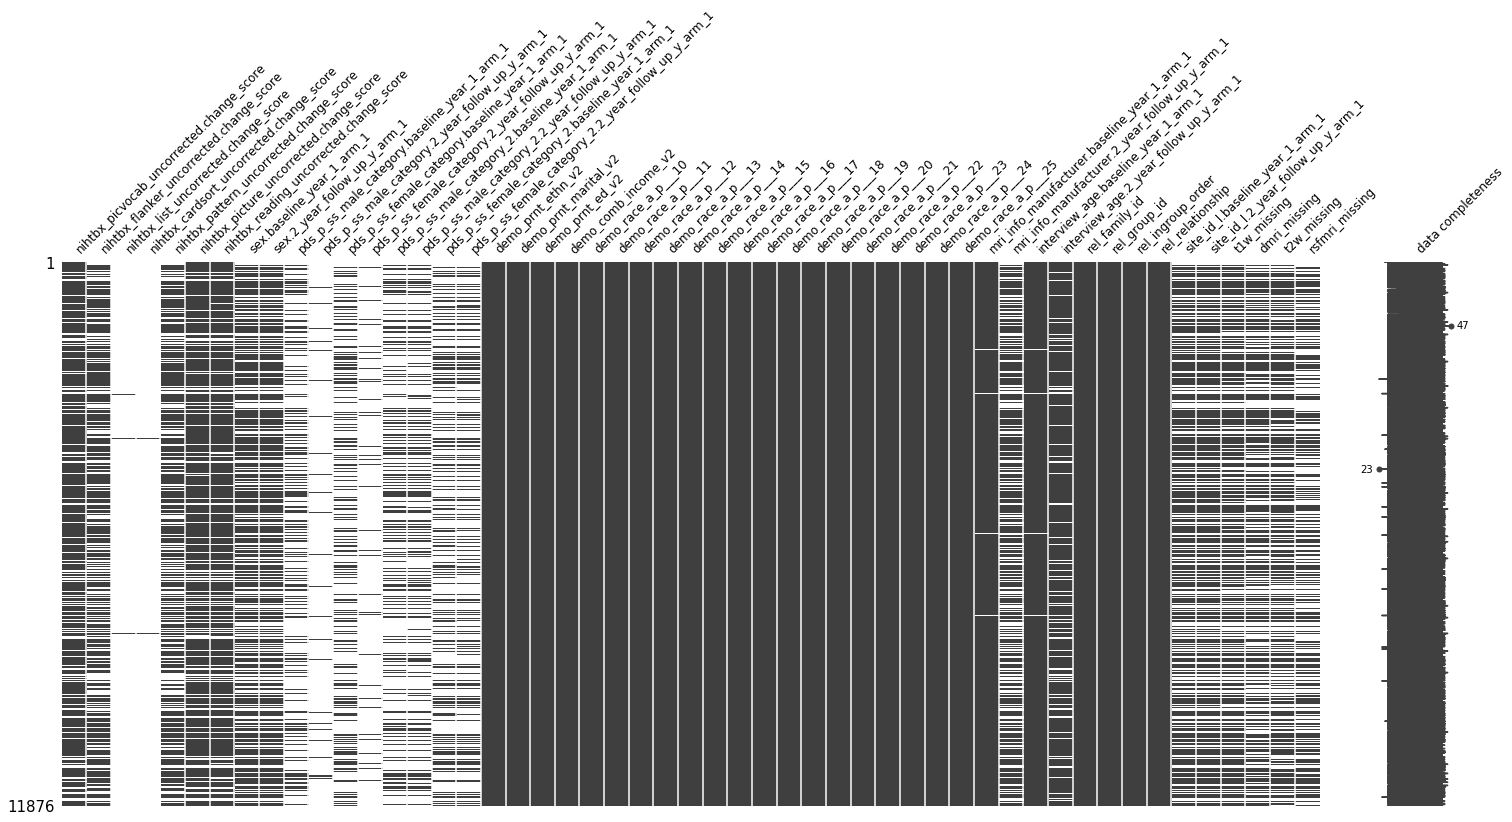

In [12]:
msno.matrix(miss_df, labels=True, fontsize=12)

In [15]:
# calculate percent misingness on each var
pct_miss = miss_df.isna().sum() / len(miss_df.index)

In [16]:
pct_miss

nihtbx_picvocab_uncorrected.change_score               0.180195
nihtbx_flanker_uncorrected.change_score                0.339087
nihtbx_list_uncorrected.change_score                   0.993937
nihtbx_cardsort_uncorrected.change_score               0.994527
nihtbx_pattern_uncorrected.change_score                0.342876
nihtbx_picture_uncorrected.change_score                0.178174
nihtbx_reading_uncorrected.change_score                0.184406
sex.baseline_year_1_arm_1                              0.341024
sex.2_year_follow_up_y_arm_1                           0.341024
pds_p_ss_male_category.baseline_year_1_arm_1           0.656871
pds_p_ss_male_category.2_year_follow_up_y_arm_1        0.948467
pds_p_ss_female_category.baseline_year_1_arm_1         0.704446
pds_p_ss_female_category.2_year_follow_up_y_arm_1      0.953772
pds_p_ss_male_category_2.baseline_year_1_arm_1         0.657039
pds_p_ss_male_category_2.2_year_follow_up_y_arm_1      0.663186
pds_p_ss_female_category_2.baseline_year

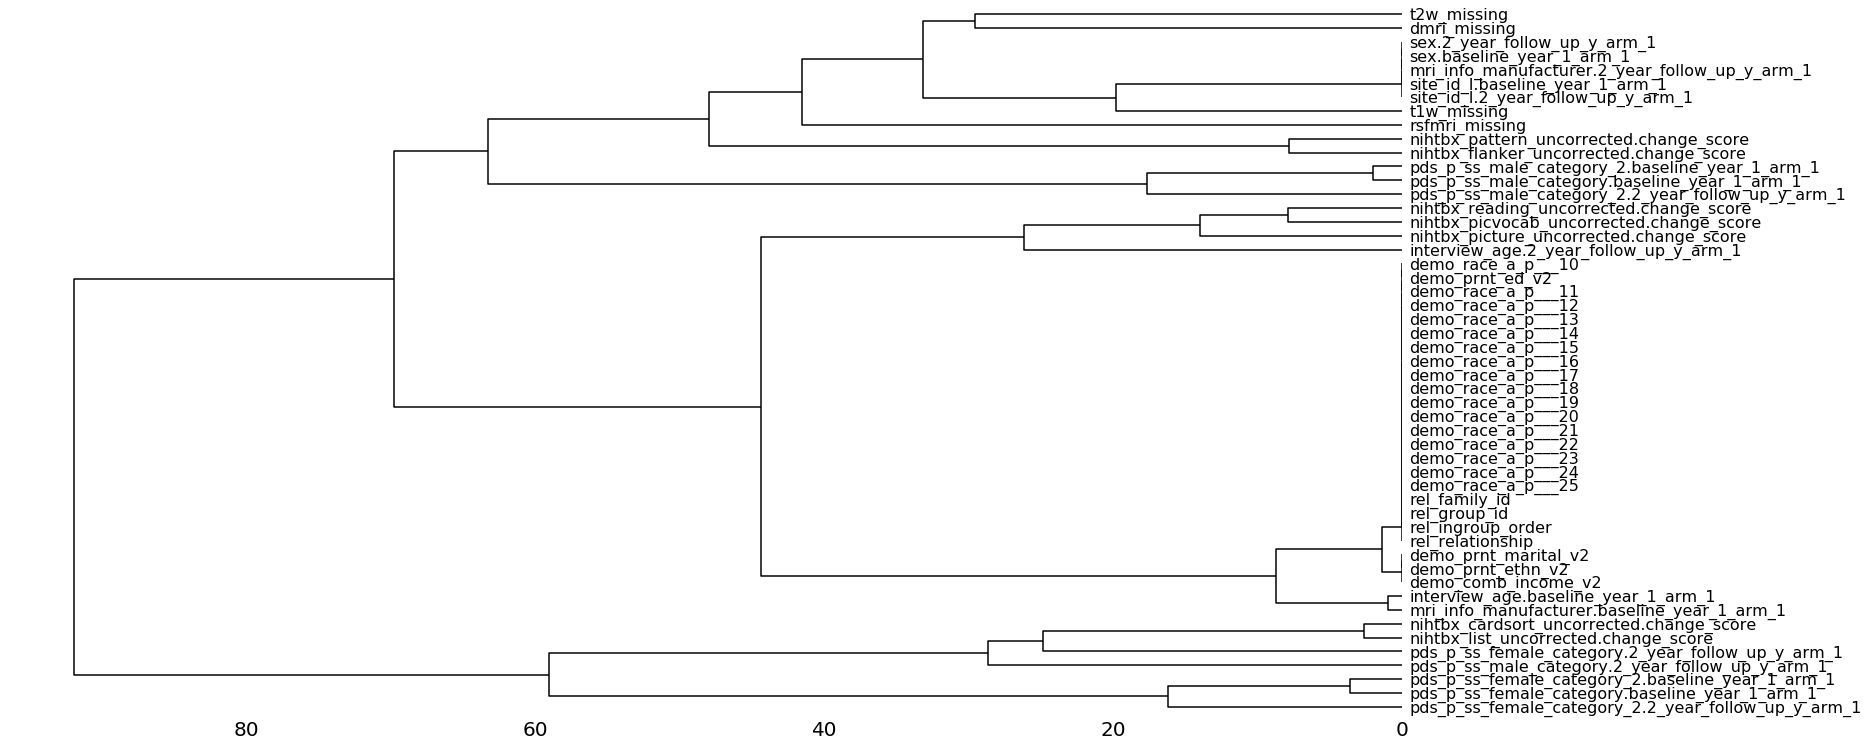

In [17]:
msno.dendrogram(miss_df)